# Sentiment Analysis with variable length sequences in pytorch

---

1. Load Data
2. Simple Data Analysis
3. Build Vocabulary and tokenize
4. Unpadded dataset and dataloader
5. Padded dataset and dataloader
6. Simple GRU model
6. GRU model with concat pooling
7. Max Pooling and Average Pooling
8. Train

## Imports

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:31:06) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.22.0
Pytorch version: 0.3.1
Spacy version: 2.0.8


## 1. Load Data

In [3]:
data_root = pathlib.Path('./data')

In [4]:
df = pd.read_csv(data_root/'Sentiment Analysis Dataset.csv', error_bad_lines=False)
df.shape
df.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


(1578612, 4)

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [5]:
df.Sentiment.value_counts()

1    790177
0    788435
Name: Sentiment, dtype: int64

## 2. Simple Data Analysis

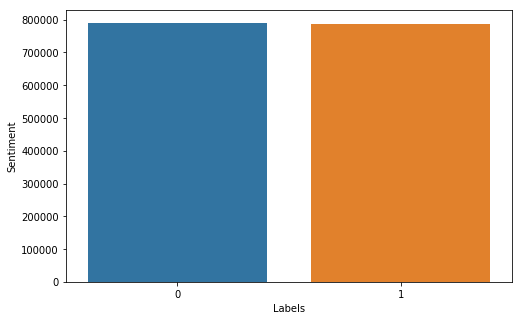

In [6]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(),y=df.Sentiment.value_counts());
ax.set(xlabel='Labels');

## 3. Build Vocabulary and tokenize

In [7]:
# load spacy tokenizer
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])

In [8]:
nlp(df.SentimentText.values[0])

                     is so sad for my APL friend.............

In [9]:
# remove leading and trailing spaces
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: x.strip())

Progress: 100%|██████████| 1578612/1578612 [00:01<00:00, 1275412.18it/s]


Use Counter to calculate the frequency of the unique words

In [10]:
words = Counter()
for sent in tqdm_notebook(df.SentimentText.values):
    words.update(w.text.lower() for w in nlp(sent))

HBox(children=(IntProgress(value=0, max=1578612), HTML(value='')))

Total unique words and top 20 most frequently occuring words

In [11]:
len(words)
words.most_common(20)

773040

[('i', 991632),
 ('!', 897920),
 ('.', 804192),
 ('to', 561225),
 (' ', 530969),
 ('the', 519913),
 (',', 480979),
 ('a', 378304),
 ('my', 313303),
 ('and', 302087),
 ('it', 301873),
 ('you', 298312),
 ('is', 244439),
 ('?', 235671),
 ('...', 219279),
 ('in', 215078),
 ('for', 214961),
 ('of', 182941),
 ("'s", 179227),
 ('that', 173790)]

Sort the words according to their frequency in the corpus

In [12]:
words = sorted(words, key=words.get, reverse=True)
words[:20]

['i',
 '!',
 '.',
 'to',
 ' ',
 'the',
 ',',
 'a',
 'my',
 'and',
 'it',
 'you',
 'is',
 '?',
 '...',
 'in',
 'for',
 'of',
 "'s",
 'that']

Add _PAD and _UNK token at the begining

In [13]:
words = ['_PAD','_UNK'] + words
words[:10]

['_PAD', '_UNK', 'i', '!', '.', 'to', ' ', 'the', ',', 'a']

Construct a mapping of words to indicies and vice versa

In [14]:
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [15]:
def indexer(s): return [word2idx[w.text.lower()] for w in nlp(s)]

### Tokenize and calculate tweet length

In [16]:
%%time
df['sentimentidx'] = df.SentimentText.apply(indexer)
df.head()

CPU times: user 2min 45s, sys: 235 ms, total: 2min 45s
Wall time: 2min 45s


In [17]:
df['lengths'] = df.sentimentidx.apply(len)
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText,sentimentidx,lengths
0,1,0,Sentiment140,is so sad for my APL friend.............,"[14, 26, 132, 18, 10, 241549, 266, 6621]",8
1,2,0,Sentiment140,I missed the New Moon trailer...,"[2, 272, 7, 90, 812, 1274, 16]",7
2,3,1,Sentiment140,omg its already 7:30 :O,"[247, 82, 217, 4573, 1012]",5
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...,"[37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454, 55...",35
4,5,0,Sentiment140,i think mi bf is cheating on me!!! T_T,"[2, 93, 1815, 1342, 14, 5521, 23, 24, 3, 3, 3,...",13


Plot the frequency distribution of the lengths of the tokenized tweets

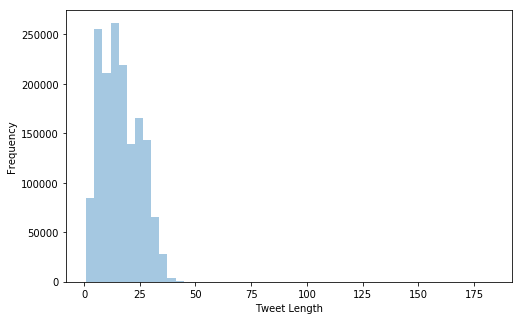

In [18]:
fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df.lengths.values,kde=False);
ax.set(xlabel='Tweet Length', ylabel='Frequency');

## The Problems

### 1. If data is not padded, then Dataloader truncates the batch to the minimum length sample in the batch. Also, data is returned as list instead of torch tensor
### 2. To get the output of the last timestep gru_out[-1] will not give the right data. Sample with lenght less than maxlen will be zeros. Instead use h[-1] to get the last timestep output
### 3. Another way of getting the last timestep output
### 4. What to do when all timesteps are required

## 4. Unpadded dataset and dataloader

In [19]:
class VectorizeData(Dataset):
    def __init__(self, df_path):
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.SentimentText.apply(lambda x: x.strip())
        self.df['sentimentidx'] = self.df.SentimentText.apply(indexer)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentidx[idx]
        y = self.df.Sentiment[idx]
        return X,y

In [20]:
ds = VectorizeData(data_root/'Sentiment Analysis Dataset.csv')
len(ds)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


1578612

Let's check the first 4 samples out of our custom dataset. It gives out the first 4 indexed sentiment and corresponding labels

In [21]:
ds[:4]

(0             [14, 26, 132, 18, 10, 241549, 266, 6621]
 1                       [2, 272, 7, 90, 812, 1274, 16]
 2                           [247, 82, 217, 4573, 1012]
 3    [37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454, 55...
 Name: sentimentidx, dtype: object, 0    0
 1    0
 2    1
 3    0
 Name: Sentiment, dtype: int64)

#### Minor Details

If the data that comes out of the pytorch dataset is unpadded (if samples are of different lengths) then pytorch dataloader returns a python list instead of pytorch tensor with samples truncated to minimum length of the sample in the batch.

First three samples are truncated to 5 (shortest tweet length in the batch) and returned as python list.

In [22]:
dl = DataLoader(dataset=ds, batch_size=3) 
print('Total batches', len(dl))

Total batches 526204


#### Each element in the xs list contains a batch (size 3) i.e. one element from each of the first 3 tweets.

In [23]:
it = iter(dl)
xs,ys = next(it)
print('Samples in batch', len(xs))
print(type(xs))
print(xs)

Samples in batch 5
<class 'list'>
[
  14
   2
 247
[torch.LongTensor of size 3]
, 
  26
 272
  82
[torch.LongTensor of size 3]
, 
 132
   7
 217
[torch.LongTensor of size 3]
, 
   18
   90
 4573
[torch.LongTensor of size 3]
, 
   10
  812
 1012
[torch.LongTensor of size 3]
]


Concatenate to form a torch tensor.

In [24]:
print(torch.stack(xs))


   14     2   247
   26   272    82
  132     7   217
   18    90  4573
   10   812  1012
[torch.LongTensor of size 5x3]



## 5. Padded dataset and dataloader

Pad the dataset and calculate the lengths of the tweets. In the below code you can see the output of padded dataset and dataloader.  
Now samples are of equal lengths and output of dataloader is LongTensor.  
Note: I have taken the max length as 10 and padded the tweets that are shorter than 10 with zeros (to the right) and truncated otherwise. We will require lengths of the tweets for the next step.

In [25]:
class VectorizeData(Dataset):
    def __init__(self, df_path, maxlen=10):
        self.maxlen = maxlen
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.SentimentText.apply(lambda x: x.strip())
        print('Indexing...')
        self.df['sentimentidx'] = self.df.SentimentText.progress_apply(indexer)
        print('Calculating lengths')
        self.df['lengths'] = self.df.sentimentidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        print('Padding')
        self.df['sentimentpadded'] = self.df.sentimentidx.progress_apply(self.pad_data)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentpadded[idx]
        lens = self.df.lengths[idx]
        y = self.df.Sentiment[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [26]:
%%time
ds = VectorizeData(data_root/'Sentiment Analysis Dataset.csv')

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'
Progress:   0%|          | 679/1578612 [00:00<03:52, 6789.39it/s]

Indexing...


Progress:  13%|█▎        | 210913/1578612 [00:00<00:01, 982265.49it/s]

Calculating lengths


Progress:   1%|▏         | 23522/1578612 [00:00<00:06, 235212.37it/s]

Padding


Progress: 100%|██████████| 1578612/1578612 [00:04<00:00, 325631.40it/s]

CPU times: user 2min 59s, sys: 585 ms, total: 2min 59s
Wall time: 2min 59s


In [27]:
print(ds[:5])

(0    [14, 26, 132, 18, 10, 241549, 266, 6621, 0, 0]
1           [2, 272, 7, 90, 812, 1274, 16, 0, 0, 0]
2         [247, 82, 217, 4573, 1012, 0, 0, 0, 0, 0]
3       [37, 241550, 4, 2, 73, 440, 6, 2, 73, 1454]
4       [2, 93, 1815, 1342, 14, 5521, 23, 24, 3, 3]
Name: sentimentpadded, dtype: object, 0    0
1    0
2    1
3    0
4    0
Name: Sentiment, dtype: int64, 0     8
1     7
2     5
3    10
4    10
Name: lengths, dtype: int64)


In [28]:
dl = DataLoader(ds, batch_size=3)
print('Total batches', len(dl))

Total batches 526204


In [29]:
it = iter(dl)
xs,ys,lens =  next(it)

In [30]:
print(type(xs))
print(xs)

<class 'torch.LongTensor'>


Columns 0 to 5 
 1.4000e+01  2.6000e+01  1.3200e+02  1.8000e+01  1.0000e+01  2.4155e+05
 2.0000e+00  2.7200e+02  7.0000e+00  9.0000e+01  8.1200e+02  1.2740e+03
 2.4700e+02  8.2000e+01  2.1700e+02  4.5730e+03  1.0120e+03  0.0000e+00

Columns 6 to 9 
 2.6600e+02  6.6210e+03  0.0000e+00  0.0000e+00
 1.6000e+01  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
[torch.LongTensor of size 3x10]



In [31]:
print('Labels:',ys)
print('Lengths:',lens)

Labels: 
 0
 0
 1
[torch.LongTensor of size 3]

Lengths: 
 8
 7
 5
[torch.LongTensor of size 3]



## 6. Simple GRU model

![Simple GRU model](data/imgs/Slide1.JPG "Simple GRU model")

In [32]:
vocab_size = len(words)
embedding_dim = 4
n_hidden = 5
n_out = 2

In [33]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
        print('Sequence shape',seq.shape)
        print('Lengths',lengths)
        bs = seq.size(1) # batch size
        print('batch size', bs)
        self.h = self.init_hidden(bs, gpu) # initialize hidden state of GRU
        print('Inititial hidden state shape', self.h.shape)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        print('GRU output(all timesteps)', gru_out.shape)
        print(gru_out)
        print('GRU last timestep output')
        print(gru_out[-1])
        print('Last hidden state', self.h)
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

In [34]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out)

In [35]:
print(m)

SimpleGRU(
  (emb): Embedding(773042, 4)
  (gru): GRU(4, 5)
  (out): Linear(in_features=5, out_features=2, bias=True)
)


Function to sort the batch according to tweet lengths

In [36]:
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

#### Run the model for 1 batch and check the output from different operations

In [37]:
dl = DataLoader(ds, batch_size=3)
it = iter(dl)
xs,ys,lens =  next(it)

In [38]:
xs,ys,lens = sort_batch(xs,ys,lens)
outp = m(xs,lens.cpu().numpy(), gpu=False) # last non zero values from gru is same as hidden output by gru

Sequence shape torch.Size([10, 3])
Lengths [8 7 5]
batch size 3
Inititial hidden state shape torch.Size([1, 3, 5])
GRU output(all timesteps) torch.Size([8, 3, 5])
Variable containing:
(0 ,.,.) = 
 -0.0977 -0.3360  0.3001  0.1199  0.0292
  0.1728 -0.3354  0.0476  0.1933 -0.1831
  0.4621 -0.3956 -0.4216  0.0412 -0.0459

(1 ,.,.) = 
 -0.0222 -0.5533  0.4437  0.1151  0.0619
  0.2546 -0.5632  0.6195  0.1897 -0.4731
  0.1960 -0.4510  0.2942  0.0257  0.1181

(2 ,.,.) = 
 -0.0631 -0.4958  0.6149 -0.3031  0.2456
  0.0964 -0.5190  0.6546  0.1902 -0.2321
  0.0204 -0.5489  0.5228  0.0522  0.1965

(3 ,.,.) = 
 -0.2234 -0.6257  0.8335  0.0432  0.1783
  0.3242 -0.6284  0.0994  0.2298 -0.2046
 -0.0477 -0.5901  0.5539 -0.1266  0.3532

(4 ,.,.) = 
 -0.1217 -0.7129  0.5814  0.2266  0.1342
  0.1820 -0.6588  0.5053  0.2825 -0.2367
 -0.0731 -0.6917  0.3815  0.0900  0.3161

(5 ,.,.) = 
  0.3669 -0.7082  0.2336 -0.0395 -0.2006
  0.3515 -0.6368  0.3156 -0.0386 -0.2894
  0.0000  0.0000  0.0000  0.0000  0.0000



In [39]:
outp

Variable containing:
-0.7109 -0.6757
-0.7237 -0.6635
-0.5778 -0.8236
[torch.FloatTensor of size 3x2]

In [40]:
torch.max(outp, dim=1)

(Variable containing:
 -0.6757
 -0.6635
 -0.5778
 [torch.FloatTensor of size 3], Variable containing:
  1
  1
  0
 [torch.LongTensor of size 3])

In [41]:
ys.shape

torch.Size([3])

Use F.nll_loss function. This function takes preditions as **(batch_size x number_of_classes)** and **(target as batch_size)**

In [42]:
F.nll_loss(outp, Variable(ys))

Variable containing:
 0.7527
[torch.FloatTensor of size 1]

### Function to train the model. I will use gpu for training. If you don't have gpu then take subset of the data as it will take quite some time to train the model on cpu.

In [43]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for X,y, lengths in t:
            t.set_description(f'Epoch {epoch}')
            X,y,lengths = sort_batch(X,y,lengths)
            X = Variable(X.cuda())
            y = Variable(y.cuda())
            lengths = lengths.numpy()
            
            model.zero_grad()
            pred = model(X, lengths, gpu=True)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.data[0])
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train.data[0]/len(train_dl)
        print(f' Epoch {epoch}: Train loss: {train_loss} acc: {train_acc}')
        
        if val_dl:
            for X,y,lengths in tqdm_notebook(valdl, leave=False):
                X, y,lengths = sort_batch(X,y,lengths)
                X = Variable(X.cuda())
                y = Variable(y.cuda())
                pred = model(X, lengths.numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = list(total_loss_val.data.float())[0]/len(valdl)
            print(f'Val loss: {valloss} acc: {valacc}')

#### I will rewrite the model without print statements

In [44]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
        bs = seq.size(1) # batch size
        self.h = self.init_hidden(bs, gpu) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

In [45]:
train_dl = DataLoader(ds, batch_size=512)
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [46]:
fit(model=m, train_dl=train_dl, val_dl=None, loss_fn=F.nll_loss, opt=opt, epochs=4)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 0: Train loss: 0.5322505490789153 acc: 0.7285754827658728


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 1: Train loss: 0.47377653406442527 acc: 0.7724228626160197


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 2: Train loss: 0.4271976060285952 acc: 0.801972872371425



## 7. GRU model with concat pooling

![GRU model with concat pooling](data/imgs/Slide2.JPG "GRU model with concat pooling")

> Concat Pooling in simple terms means taking max and average of output of all timesteps and then concatenating them along with the last hidden state before passing it is output layer.  
Refer Concat Pooling section in this [paper](https://arxiv.org/abs/1801.06146).

* We can pass the output of GRU to Adaptive Max pooling and  Adaptive Avg pooling functions of pytorch. But there is a problem with this method. 
* Since GRU output is padded to longest length sample, the average taken by F.adaptive_avg_pool1d() maybe lower than the actual because the zero padding will also be accounted.
* Similarly the max pooling taken by F.adaptive_max_pool1d() maybe higher than the actual because if the hidden state contains negative value then with zero padding, zero will be taken as max instead of negative value (refer output below)

In [47]:
class ConcatPoolingGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
        self.h = self.init_hidden(seq.size(1), gpu)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        print('Adaptive avg pooling', avg_pool)
        # adaptive avg pooling by hand
        # taking the sum along the batch axis and dividing by the corresponding lengths to get the actual mean
        avg_pool_byhand = torch.sum(gru_out, dim=0)/Variable(torch.FloatTensor(lengths).view(-1,1)) 
        print('By hand Adaptive avg pooling', avg_pool_byhand)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        print('Adaptive max pooling', max_pool)
        # adaptive max pooling by hand
        # collect all the non padded elements of the batch and then take max of them
        max_pool_byhand = torch.cat([torch.max(i[:l], dim=0)[0].view(1,-1) for i,l in zip(gru_out.permute(1,0,2), lengths)], dim=0) 
        print('By hand Adaptive max pooling', max_pool_byhand)

#         outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))
        outp = self.out(torch.cat([self.h[-1],avg_pool_byhand,max_pool_byhand],dim=1))
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

In [48]:
m = ConcatPoolingGRU(vocab_size, embedding_dim, n_hidden, n_out)
print(m)

ConcatPoolingGRU(
  (emb): Embedding(773042, 4)
  (gru): GRU(4, 5)
  (out): Linear(in_features=15, out_features=2, bias=True)
)


#### Run the model for 1 batch and check the output from different operations

In [49]:
dl = DataLoader(ds, batch_size=3)
it = iter(dl)
xs,ys,lens =  next(it)

In [50]:
xs,ys,lens = sort_batch(xs,ys,lens)
outp = m(xs,lens.cpu().numpy(), gpu=False)

Adaptive avg pooling Variable containing:
 0.1202  0.5437 -0.1520 -0.2798 -0.0858
 0.0709  0.2935 -0.1764  0.1605 -0.2498
-0.1279  0.1380 -0.0289  0.1256 -0.2533
[torch.FloatTensor of size 3x5]

By hand Adaptive avg pooling Variable containing:
 0.1202  0.5437 -0.1520 -0.2798 -0.0858
 0.0810  0.3355 -0.2016  0.1834 -0.2855
-0.2047  0.2209 -0.0463  0.2010 -0.4052
[torch.FloatTensor of size 3x5]

Adaptive max pooling Variable containing:
 0.3386  0.7435  0.2077  0.1641  0.0561
 0.4527  0.6197  0.2627  0.4935  0.0000
 0.0000  0.5059  0.2801  0.4368  0.0000
[torch.FloatTensor of size 3x5]

By hand Adaptive max pooling Variable containing:
 0.3386  0.7435  0.2077  0.1641  0.0561
 0.4527  0.6197  0.2627  0.4935 -0.0720
-0.0023  0.5059  0.2801  0.4368 -0.2812
[torch.FloatTensor of size 3x5]



In [51]:
outp

Variable containing:
-0.6616 -0.7257
-0.7196 -0.6673
-0.7732 -0.6190
[torch.FloatTensor of size 3x2]

In [52]:
torch.max(outp, dim=1)

(Variable containing:
 -0.6616
 -0.6673
 -0.6190
 [torch.FloatTensor of size 3], Variable containing:
  0
  1
  1
 [torch.LongTensor of size 3])

#### I will rewrite the model without print statements  
#### Model with custom max and avg pooling

In [53]:
class ConcatPoolingGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
        self.h = self.init_hidden(seq.size(1), gpu)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)
        # adaptive avg pooling by hand
        # taking the sum along the batch axis and dividing by the corresponding lengths to get the actual mean
        avg_pool_byhand = torch.sum(gru_out, dim=0)/Variable(torch.FloatTensor(lengths).cuda().view(-1,1)) 
        # adaptive max pooling by hand
        # collect all the non padded elements of the batch and then take max of them
        max_pool_byhand = torch.cat([torch.max(i[:l], dim=0)[0].view(1,-1) for i,l in zip(gru_out.permute(1,0,2), lengths)], dim=0) 

        outp = self.out(torch.cat([self.h[-1],avg_pool_byhand,max_pool_byhand],dim=1))
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

In [54]:
train_dl = DataLoader(ds, batch_size=512)
m = ConcatPoolingGRU(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

fit(model=m, train_dl=train_dl, val_dl=None, loss_fn=F.nll_loss, opt=opt, epochs=4)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 0: Train loss: 0.5296392576858382 acc: 0.7309459195799854


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 1: Train loss: 0.4718990894916302 acc: 0.7737556790395613


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 2: Train loss: 0.4243553547543774 acc: 0.804055081299268



#### Model with pytorch Adaptive max and avg pooling

In [55]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
        self.h = self.init_hidden(seq.size(1), gpu)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)

        outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))             
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

In [56]:
train_dl = DataLoader(ds, batch_size=512)
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

fit(model=m, train_dl=train_dl, val_dl=None, loss_fn=F.nll_loss, opt=opt, epochs=4)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 0: Train loss: 0.5329634571199132 acc: 0.7296422426790117


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 1: Train loss: 0.4745105392119609 acc: 0.7721473040873882


HBox(children=(IntProgress(value=0, max=1542), HTML(value='')))

 Epoch 2: Train loss: 0.42477725730331956 acc: 0.8031549234390718

